In [83]:
"""
ref: 
https://m.blog.naver.com/gdpresent/221717318894

"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

# Models
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [40]:
# base param
seed = 712

In [41]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=712)

In [75]:
def score(X_train, y_train, X_test, y_test, model):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"score - train: {train_score}, test: {test_score}")

def metrics(true_label, predict_label):
    roc = roc_auc_score(true_label, predict_label)
    f1 = f1_score(true_label, predict_label)
    print(f"test metrics - roc: {roc}, f1: {f1}")

# Decision Tree

In [43]:
tree_clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=seed)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=712)

[Text(511.5, 475.65000000000003, 'worst perimeter <= 105.95\nentropy = 0.957\nsamples = 455\nvalue = [172, 283]\nclass = benign'),
 Text(279.0, 339.75, 'worst concave points <= 0.161\nentropy = 0.292\nsamples = 273\nvalue = [14, 259]\nclass = benign'),
 Text(186.0, 203.85000000000002, 'mean texture <= 21.315\nentropy = 0.176\nsamples = 266\nvalue = [7, 259]\nclass = benign'),
 Text(93.0, 67.94999999999999, 'entropy = 0.043\nsamples = 214\nvalue = [1, 213]\nclass = benign'),
 Text(279.0, 67.94999999999999, 'entropy = 0.516\nsamples = 52\nvalue = [6, 46]\nclass = benign'),
 Text(372.0, 203.85000000000002, 'entropy = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = malignant'),
 Text(744.0, 339.75, 'worst perimeter <= 117.45\nentropy = 0.563\nsamples = 182\nvalue = [158, 24]\nclass = malignant'),
 Text(558.0, 203.85000000000002, 'worst smoothness <= 0.135\nentropy = 0.99\nsamples = 52\nvalue = [29, 23]\nclass = malignant'),
 Text(465.0, 67.94999999999999, 'entropy = 0.837\nsamples = 30\nvalue = 

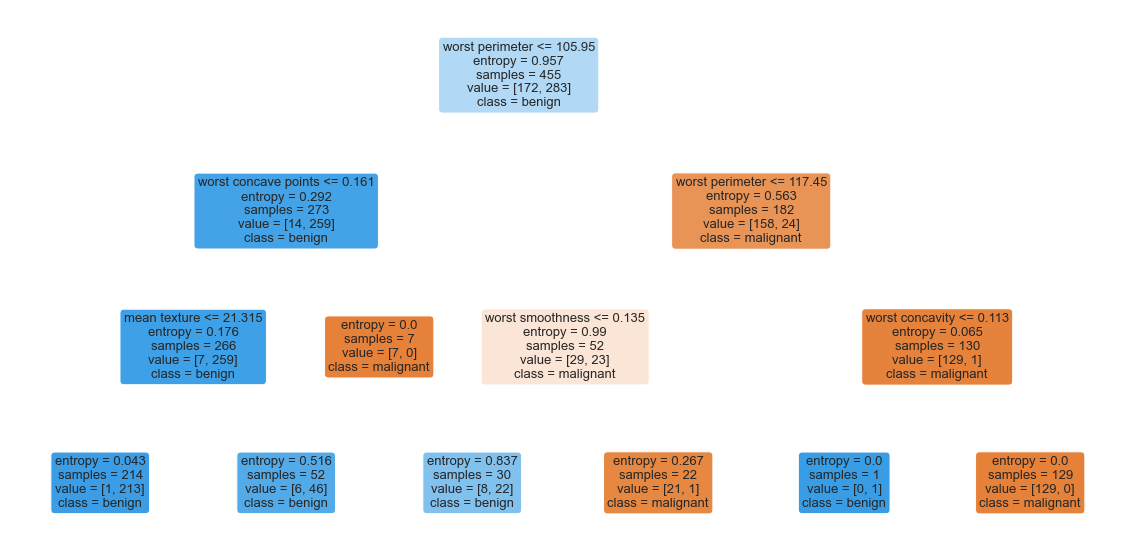

In [47]:
plt.figure( figsize=(20,10) )
tree.plot_tree(tree_clf,
               class_names=cancer.target_names,
               feature_names=cancer.feature_names,
               impurity=True, filled=True,
               rounded=True)

In [76]:
score(X_train, y_train, X_test, y_test, tree_clf)
metrics(y_test, tree_clf.predict(X_test))

score - train: 0.9648351648351648, test: 0.956140350877193
test metrics - roc: 0.9547297297297297, f1: 0.9659863945578231


In [85]:
# classification report
classification_report(y_test, tree_clf.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.93      0.95      0.94        40\n           1       0.97      0.96      0.97        74\n\n    accuracy                           0.96       114\n   macro avg       0.95      0.95      0.95       114\nweighted avg       0.96      0.96      0.96       114\n'

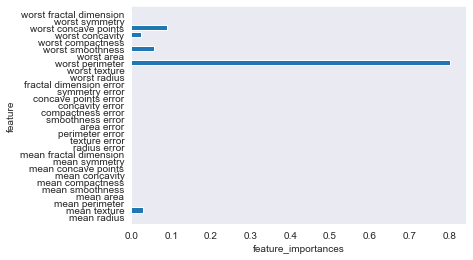

In [88]:
# feature importance

def plot_feature_importances(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features),
            model.feature_importances_,
            align='center')
    plt.yticks(np.arange(n_features),
              cancer.feature_names)
    plt.xlabel("feature_importances")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)
    plt.show()
    
plot_feature_importances(tree_clf)

mean radius : 0.000
mean texture : 0.029
mean perimeter : 0.000
mean area : 0.000
mean smoothness : 0.000
mean compactness : 0.000
mean concavity : 0.000
mean concave points : 0.000
mean symmetry : 0.000
mean fractal dimension : 0.000
radius error : 0.000
texture error : 0.000
perimeter error : 0.000
area error : 0.000
smoothness error : 0.000
compactness error : 0.000
concavity error : 0.000
concave points error : 0.000
symmetry error : 0.000
fractal dimension error : 0.000
worst radius : 0.000
worst texture : 0.000
worst perimeter : 0.803
worst area : 0.000
worst smoothness : 0.056
worst compactness : 0.000
worst concavity : 0.023
worst concave points : 0.090
worst symmetry : 0.000
worst fractal dimension : 0.000


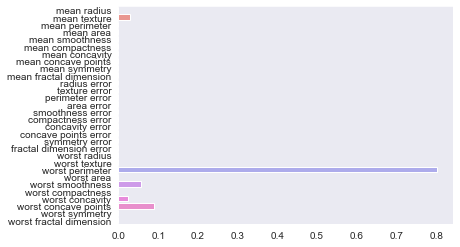

In [90]:
# feature별 importance 매핑
for name, value in zip(cancer.feature_names , tree_clf.feature_importances_):
    print('{} : {:.3f}'.format(name, value))
    
# feature importance를 column 별로 시각화 하기
sns.barplot(x=tree_clf.feature_importances_ , y=cancer.feature_names)

## Neural Network

In [53]:
nn_clf = MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(10,4), random_state=seed)
nn_clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 4), random_state=712,
              solver='lbfgs')

In [54]:
nn_clf.predict(X_test)

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0])

In [55]:
# 5. weights 확인
nn_clf.coefs_

# 5. layer shape 확인
[coef.shape for coef in  nn_clf.coefs_]

[(30, 10), (10, 4), (4, 1)]

In [77]:
score(X_train, y_train, X_test, y_test, nn_clf)
metrics(y_test, nn_clf.predict(X_test))

score - train: 0.9494505494505494, test: 0.9298245614035088
test metrics - roc: 0.9287162162162163, f1: 0.9452054794520548


## Boosting

In [64]:
ada_clf = AdaBoostClassifier(base_estimator=tree_clf,
                            n_estimators=1000,
                            learning_rate=1.,
                            random_state=seed)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         random_state=712),
                   n_estimators=1000, random_state=712)

In [78]:
score(X_train, y_train, X_test, y_test, ada_clf)
metrics(y_test, ada_clf.predict(X_test))

score - train: 1.0, test: 0.9736842105263158
test metrics - roc: 0.9739864864864864, f1: 0.979591836734694


In [80]:
grad_clf = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=10000,
    max_depth = 3, # no more than 5 usually
    max_features=0.6,
    subsample=0.7,
    random_state=seed
)
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier(max_features=0.6, n_estimators=10000,
                           random_state=712, subsample=0.7)

In [81]:
score(X_train, y_train, X_test, y_test, grad_clf)
metrics(y_test, grad_clf.predict(X_test))

score - train: 1.0, test: 0.956140350877193
test metrics - roc: 0.9662162162162162, f1: 0.965034965034965


In [82]:
grad_clf.feature_importances_

array([4.17965351e-03, 2.74241953e-02, 1.58262337e-03, 3.02577852e-03,
       6.49365808e-03, 3.55902109e-03, 1.17294512e-02, 1.37264830e-01,
       3.48358164e-03, 6.81975793e-05, 5.25647238e-03, 2.54681060e-03,
       6.99650242e-03, 1.06096095e-02, 6.69258481e-03, 2.91973862e-03,
       3.44657566e-03, 1.22260014e-03, 1.96729479e-03, 5.10272665e-03,
       7.52375449e-02, 4.27596035e-02, 3.22995345e-01, 1.03964088e-01,
       5.34284575e-03, 1.11849622e-03, 1.03022679e-02, 1.87013549e-01,
       4.23446555e-03, 1.45988825e-03])

## SVM

## K-NN